In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import time
import itertools
import random
import os
import shutil
from math import floor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, RMSprop
from torch.utils.data import DataLoader, random_split

from torchvision import transforms
from torchvision.datasets import ImageFolder

from skorch import NeuralNetClassifier

from skopt import BayesSearchCV
from skopt.space.space import Integer, Categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [2]:
# set torch manual seed for reproducibility
torch.manual_seed(0)

# cuda checks
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080'

In [3]:
# constants
data_root = './data/'
raw_data_filepath = data_root+'raw_data/'
single_knee_data_filepath = data_root+'single_knee_images/'

labels_map = {
    0: "G0 Normal",
    1: "G1 Doubtful",
    2: "G2 Mild",
    3: "G3 Moderate",
    4: "G4 Severe"
}

test_split = 0.25
batch_size = 32

In [4]:
# helper functions
def img_loader(filename):
    
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

def plot_random_selection_of_images(dataset, rows=3, cols=3):
    figure = plt.figure()
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

## Preliminary data analysis

In [6]:
# load the raw data as a pytorch dataset
raw_data = ImageFolder(root=raw_data_filepath, loader=img_loader)

In [7]:
# class indexes
classes = raw_data.classes
class_to_idx = raw_data.class_to_idx
print(classes)

['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']


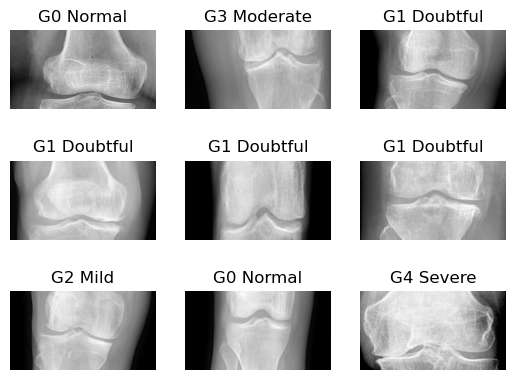

In [14]:
# visualise a random selection of images
plot_random_selection_of_images(raw_data)

In [16]:
# number of images
samples = raw_data.samples

tot_num_images = len(raw_data)
print('Total number of images in the raw data: ', tot_num_images)
print('---')
print('Number of images in each class:')
for i in range(len(raw_data.classes)):
    num_images_in_class = sum([1 for _, label in raw_data.samples if label == i])
    print(f'{labels_map[i]}: {num_images_in_class} ({round(num_images_in_class/tot_num_images*100)}%)')

Total number of images in the raw data:  1650
---
Number of images in each class:
G0 Normal: 514 (31%)
G1 Doubtful: 477 (29%)
G2 Mild: 232 (14%)
G3 Moderate: 221 (13%)
G4 Severe: 206 (12%)


In [18]:
img_shape_filename_class = []
for i in range(len(raw_data)):
    img_shape_filename_class.append([raw_data[i][0].shape, samples[i]])

unique_shapes = list(set([shape for shape, sample in img_shape_filename_class]))
print('Unique image sizes:')
print(unique_shapes)

Unique image sizes:
[(162, 300), (161, 640)]


**We can see that the dataset includes two sizes of images.**

In [21]:
# seperate out the samples of the two different image types
size_300 = []
size_640 = []
for i in range(len(raw_data)):
    if raw_data[i][0].shape == (162, 300):
        size_300.append(samples[i])
    else:
        size_640.append(samples[i])

num_size_640 = len(size_640)
num_size_300 = tot_num_images - num_size_640
print(f'Total number of (162 x 640) images: {num_size_640}')
print(f'Total number of (161 x 300) images: {num_size_300}')

print('---')
print('Number of each size of image in each class:')
for i in range(len(raw_data.classes)):
    num_images_in_class = sum([1 for _, label in raw_data.samples if label == i])
    num_size_640_in_class = sum([1 for _, label in size_640 if label == i])
    num_size_300_in_class = num_images_in_class - num_size_640_in_class
    print(labels_map[i], ':')
    print(f'(162 x 640): {num_size_640_in_class} ({round(num_size_640_in_class/tot_num_images*100)}% of total)')
    print(f'(161 x 300): {num_size_300_in_class} ({round(num_size_300_in_class/tot_num_images*100)}% of total)')

Total number of (162 x 640) images: 186
Total number of (161 x 300) images: 1464
---
Number of each size of image in each class:
G0 Normal :
(162 x 640): 62 (4% of total)
(161 x 300): 452 (27% of total)
G1 Doubtful :
(162 x 640): 37 (2% of total)
(161 x 300): 440 (27% of total)
G2 Mild :
(162 x 640): 41 (2% of total)
(161 x 300): 191 (12% of total)
G3 Moderate :
(162 x 640): 46 (3% of total)
(161 x 300): 175 (11% of total)
G4 Severe :
(162 x 640): 0 (0% of total)
(161 x 300): 206 (12% of total)


**Let's compare the different sizes of images:**

In [24]:
image_300_filenames = [filename for filename, label in size_300]
image_640_filenames = [filename for filename, label in size_640]

data_300 = ImageFolder(root=raw_data_filepath, loader=img_loader, is_valid_file=lambda filename: filename in image_300_filenames)
data_640 = ImageFolder(root=raw_data_filepath, loader=img_loader, is_valid_file=lambda filename: filename in image_640_filenames, allow_empty=True)

Random sample of the (161 x 300) images:


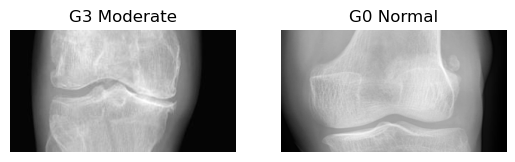

In [26]:
print('Random sample of the (161 x 300) images:')
plot_random_selection_of_images(data_300, 1, 2)

Random sample of the (162 x 640) images:


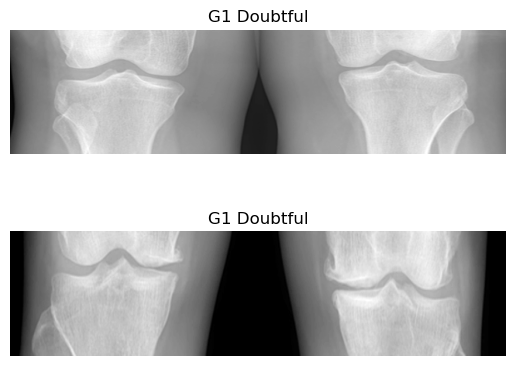

In [28]:
print('Random sample of the (162 x 640) images:')
plot_random_selection_of_images(data_640, 2, 1)

**We can see that the larger (162 x 640) images are x-rays of both knees together while the smaller (162 x 300) images contain only a single knee.**

## Data pre-processing 

For now, we will use just use the images of the single knees to test and train our model. There are significantly fewer images of two knees together, and none in the G4 category. Hence, it is easiest to remove them. 

It might be possible in future to split the two-knee images into two single knee images and add them back into the dataset.

The single knee images can be found in './data/single_knee_images/'

## Data loading

In [34]:
def load_datasets():
    transform  = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = ImageFolder(root=single_knee_data_filepath, loader=img_loader, transform=transform)
    total_size = len(dataset)
    test_size = int(test_split * total_size)
    train_size = total_size - test_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset

def get_data_from_datasets(train_dataset, test_dataset):
    train_images, train_labels = zip(*train_dataset)
    test_images, test_labels = zip(*test_dataset)
    
    X_train = np.stack([image.numpy() for image in train_images])
    X_test = np.stack([image.numpy() for image in test_images])

    y_train =  torch.LongTensor(train_labels)
    y_test = torch.LongTensor(test_labels)
    
    return X_train, y_train, X_test, y_test

def get_loaders(train_dataset, test_dataset):
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, testloader

In [36]:
# load the data
train_dataset, test_dataset = load_datasets()
trainloader, testloader = get_loaders(train_dataset, test_dataset)
X_train, y_train, X_test, y_test = get_data_from_datasets(train_dataset, test_dataset)

## Building the initial CNN

Let's build a LeNet CNN with 2 convolution layers, 2 max pooling layers and and 3 fully connected layers

In [39]:
class CNNModel(nn.Module):
    def __init__(self, 
                 name):
        super(CNNModel, self).__init__()
        self.name = name
        self.to(torch.device("cuda:0"))
        
        # network structure
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(42624, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 42624)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [42]:
def train(net, optimizer_name, lr, num_epochs, trainloader):
    optimizers = {
        'Adam': Adam(net.parameters(), lr=lr),
    }
    
    optimizer = optimizers[optimizer_name]
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            optimizer.zero_grad()
    
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    print('Finished Training')
    end = time.time()
    print('training time ', round(end-start, 2), 's')
    print('---')

In [44]:
def test(net, testloader):
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.append(labels.tolist())
            y_pred.append(predicted.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

    num_output_classes = len(classes)
    class_correct = list(0. for i in range(num_output_classes))
    class_total = list(0. for i in range(num_output_classes))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels)
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    for i in range(num_output_classes):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    y_true = list(itertools.chain.from_iterable(y_true))
    y_pred = list(itertools.chain.from_iterable(y_pred))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot()
    plt.show()

**Train and test the initial model**

LeNet5: total params: 5128161
Finished Training
training time  11.61 s
---
Accuracy of the network on the test images: 45 %
Accuracy of 0Normal : 55 %
Accuracy of 1Doubtful : 62 %
Accuracy of 2Mild :  7 %
Accuracy of 3Moderate : 25 %
Accuracy of 4Severe : 33 %


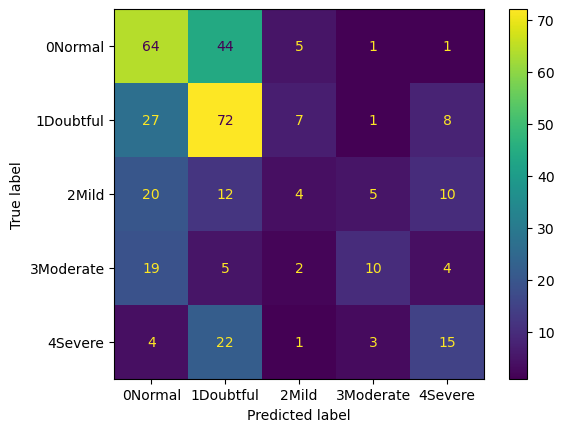

In [47]:
optimizer_name = 'Adam'
lr=0.0001
num_epochs=5

name = 'LeNet5'
initial_net = CNNModel(name)

train(initial_net, 
      optimizer_name, 
      lr, 
      num_epochs,
      trainloader)
test(initial_net, testloader)

**Initial accuracy on the test data is 45%**

## Optimising the hyperparameters

### Part 1

**Now let's try optimise the learning rate and number of epochs using BayesSearchCV**

In [51]:
knee_knet = NeuralNetClassifier(
    CNNModel,
    module__name="KneeKnet",
    lr=0.001,
    optimizer=torch.optim.Adam,
    max_epochs=5,
    criterion = nn.CrossEntropyLoss,
    batch_size = 32,
    device='cuda'
)

# Define the hyperparameter search space
hyperparam_space = {
    'max_epochs': Integer(5,40),
    'lr': (1e-5, 1e-2, 'log-uniform'),
}

opt = BayesSearchCV(
    knee_knet,
    hyperparam_space,
    cv=3,
    random_state=0,
    n_iter = 20
)
opt.fit(X_train, y_train)

KneeKnet: total params: 5128161
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5458       0.3129        1.5189  0.3025
      2        1.5187       0.3537        1.4614  0.1217
      3        1.4603       0.4014        1.4084  0.1182
      4        1.3890       0.4014        1.3754  0.1151
      5        1.3116       0.4490        1.3591  0.1140
      6        1.2275       0.4014        1.3723  0.1166
      7        1.1493       0.4490        1.3072  0.1165
      8        1.0698       0.4966        1.3098  0.1134
      9        1.0090       0.4966        1.3318  0.1168
     10        0.9502       0.4558        1.3560  0.1153
     11        0.8945       0.4694        1.3695  0.1142
     12        0.8247       0.4558        1.4029  0.1138
     13        0.7719       0.4694        1.3985  0.1191
     14        0.7035       0.4694        1.3812  0.1276
     15        0.6392       0.4830        1.4556  0.1299

BayesSearchCV(cv=3,
              estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.CNNModel'>,
  module__name=KneeKnet,
),
              n_iter=20, random_state=0,
              search_spaces={'lr': (1e-05, 0.01, 'log-uniform'),
                             'max_epochs': Integer(low=5, high=40, prior='uniform', transform='normalize')})

In [53]:
print(opt.best_params_)
print('Accuracy on the training set:', round(opt.score(X_train, y_train), 2))
print('Accuracy on the test set:', round(opt.score(X_test, y_test), 2))

OrderedDict({'lr': 0.0008851615139121367, 'max_epochs': 40})
Accuracy on the training set: 0.91
Accuracy on the test set: 0.54


**Accuracy has increased to 54%**

- Best lr: 0.0008851615139121367,
- Best max_epochs: 40

Note, results may vary each time the code is run

In [55]:
def show_accuracy_by_class(net):
    net.fit(X_train, y_train)
    y_pred = net.predict(X_test)

    print('Accuracy of the network on the test images:', round(net.score(X_test, y_test),2)*100, '%')
    
    for cl in classes:
        true_indices = np.where(np.array(y_test) == class_to_idx[cl])[0]
    
        if len(true_indices) == 0:
            class_accuracy[cl] = None
            continue
        
        correct_predictions = np.sum(np.array(y_test)[true_indices] == np.array(y_pred)[true_indices])
        
        accuracy = (correct_predictions / len(true_indices)) * 100
        print(f'Accuracy of {cl}: {round(accuracy)}%')

    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot()
    plt.show()

KneeKnet: total params: 5128161
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5229       0.3682        1.4676  0.4666
      2        1.4477       0.3955        1.3872  0.1677
      3        1.3476       0.4500        1.3692  0.1679
      4        1.2444       0.4545        1.2986  0.1689
      5        1.1391       0.5091        1.2290  0.1731
Accuracy of the network on the test images: 54.0 %
Accuracy of 0Normal: 61%
Accuracy of 1Doubtful: 65%
Accuracy of 2Mild: 12%
Accuracy of 3Moderate: 57%
Accuracy of 4Severe: 51%


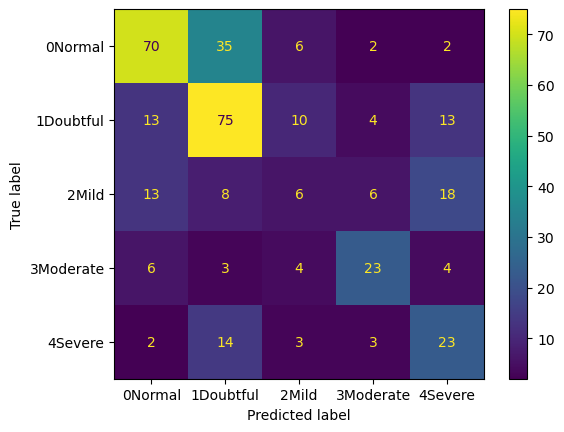

In [57]:
show_accuracy_by_class(knee_knet)

### Part 2

**Let's see if we can optimise the convolution kernel size and number of convolution layers using GridSearchCV**

In [63]:
class DynamicCNNModel(nn.Module):
    def __init__(self, 
                 name, 
                 conv_kernel_size,
                 conv_filters,
                 num_conv_layers):
        super(DynamicCNNModel, self).__init__()
        self.to(torch.device("cuda:0"))
        self.name = name
        self.input_height = 162
        self.input_width = 300
        input_channels = 1
        num_categories = 5

        self.conv_kernel_size = conv_kernel_size
        self.conv_filters = conv_filters
        self.num_conv_layers = num_conv_layers
        self.input_features_fc1 = self.calculate_num_input_features_fc1()

        self.conv1 = nn.Conv2d(input_channels, conv_filters, conv_kernel_size) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(conv_filters, conv_filters, conv_kernel_size)
        self.fc1 = nn.Linear( self.input_features_fc1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    # calculate how many input features we have in the first fully connected layer
    def calculate_num_input_features_fc1(self):
        def calculate_output_dim(input_size, kernel_size, stride=1, padding = 0):
            return floor((input_size - kernel_size + 2 * padding) / stride) + 1

        height = self.input_height
        width = self.input_width
        for i in range(self.num_conv_layers):
            height = calculate_output_dim(height, self.conv_kernel_size)
            width = calculate_output_dim(width, self.conv_kernel_size)
            height = calculate_output_dim(height, 2, 2)
            width = calculate_output_dim(width, 2, 2)

        return height * width * self.conv_filters   

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        for _ in range(self.num_conv_layers - 1):
            x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(-1, self.input_features_fc1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [65]:
knee_knet = NeuralNetClassifier(
    DynamicCNNModel,
    module__name="KneeKnet",
    module__conv_kernel_size = 5,
    module__conv_filters = 16,
    module__num_conv_layers = 2,
    lr=0.0008851615139121367,
    optimizer=torch.optim.Adam,
    max_epochs=40,
    criterion = nn.CrossEntropyLoss,
    batch_size = 32,
    device='cuda'
)

# Define the hyperparameter search space
hyperparam_space = {
    'module__conv_kernel_size': [2, 3, 4, 5],
    'module__num_conv_layers': [2, 3],
    'module__conv_filters': [16, 64, 128]
}

opt = GridSearchCV(
    knee_knet,
    hyperparam_space,
)
opt.fit(X_train, y_train)

KneeKnet: total params: 5552949
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5784       0.3636        1.4928  0.5308
      2        1.4497       0.3409        1.5079  0.1666
      3        1.3469       0.4091        1.4052  0.1620
      4        1.2273       0.4091        1.3672  0.1651
      5        1.1230       0.4602        1.3441  0.1629
      6        1.0348       0.4773        1.3674  0.1637
      7        0.9481       0.4545        1.3550  0.1613
      8        0.8699       0.4830        1.3251  0.1730
      9        0.7464       0.4943        1.3614  0.1823
     10        0.6483       0.4659        1.4558  0.1828
     11        0.5627       0.4602        1.5093  0.1803
     12        0.5441       0.5114        1.5155  0.2033
     13        0.4353       0.4943        1.6161  0.1826
     14        0.3348       0.4773        1.8219  0.1613
     15        0.3064       0.4091        2.1831  0.1624

GridSearchCV(estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.DynamicCNNModel'>,
  module__conv_filters=16,
  module__conv_kernel_size=5,
  module__name=KneeKnet,
  module__num_conv_layers=2,
),
             param_grid={'module__conv_filters': [16, 64, 128],
                         'module__conv_kernel_size': [2, 3, 4, 5],
                         'module__num_conv_layers': [2, 3]})

In [68]:
print(opt.best_params_)
print('Accuracy on the training set:', round(opt.score(X_train, y_train), 2))
print('Accuracy on the test set:', round(opt.score(X_test, y_test), 2))

{'module__conv_filters': 64, 'module__conv_kernel_size': 4, 'module__num_conv_layers': 2}
Accuracy on the training set: 0.88
Accuracy on the test set: 0.59


- Best number convolution layers: 2
- Best kernel size: 4
- Best number kernel filters: 64

**Accuracy has increased to 59%**

## Final Network

Hyperparameters:
- Max epochs: 40
- Learning rate: 0.0008851615139121367 
- Number convolution layers: 2
- K kernel si: :
- Nst number kernel fil: rs: 64

Re-initializing module because the following parameters were re-set: conv_filters, conv_kernel_size, name, num_conv_layers.
KneeKnet: total params: 5132421
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5055       0.4409        1.4608  0.4448
      2        1.4287       0.4455        1.3832  0.2281
      3        1.3447       0.5091        1.3059  0.2334
      4        1.2080       0.4818        1.2619  0.2362
      5        1.0808       0.4955        1.2191  0.2296
      6        0.9604       0.5182        1.2130  0.2299
      7        0.8486       0.5045        1.2356  0.2351
      8        0.7589       0.4818        1.3589  0.2368
      9        0.7203       0.4909        1.4132  0.2274
     10        0.6212       0.4682        1.5756  0.2244
     11        0.5365       0.5091        1.6636  0.2277
     12        0.4527       0.4818        1.7636 

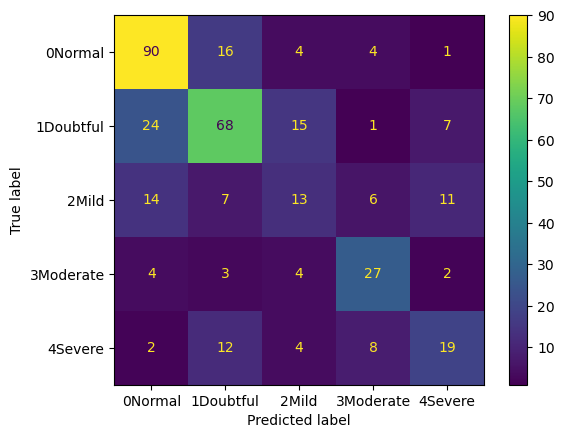

In [76]:
show_accuracy_by_class(knee_knet)